In [81]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ── 0) Generate the clean signal f(x), add noise, and build x,y arrays ─────

T = 1000
x = np.linspace(-3.5, 3.5, T)
f = 0.5 * x**4 - (x + 1)**3 - 3 * x**2
noise = np.random.normal(0, 12, T)
y = f + noise  # noisy signal

# ── 1) Build overlapping windows of size 50 ──────────────────────────────────

window_size = 50

def create_windows(signal, w):
    N = len(signal)
    return np.stack([signal[i : i + w] for i in range(N - w + 1)], axis=0)

X_w = create_windows(y, window_size)                     # shape: (T - 49, 50)
X_tensor = torch.tensor(X_w, dtype=torch.float32)        # shape: (num_windows, 50)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

# ── 2) Define a simple VAE (encoder → latent_dim=2 → decoder) ───────────────

class VAE(nn.Module):
    def __init__(self, input_dim=50, hidden_dim=32, latent_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.mu_layer(h), self.logvar_layer(h)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu2(self.fc2(z))
        return self.out(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

vae = VAE(input_dim=window_size, hidden_dim=32, latent_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
mse = nn.MSELoss(reduction='sum')

def loss_fn(recon, orig, mu, logvar):
    recon_loss = mse(recon, orig)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

# ── 3) Train for 30 epochs ────────────────────────────────────────────────────

vae.train()
for epoch in range(30):
    total = 0.0
    for batch in loader:
        batch_x = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch_x)
        loss = loss_fn(recon_batch, batch_x, mu, logvar)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch+1:02d}/30, Loss per window: {total / len(loader.dataset):.4f}")

# ── 4) Reconstruct every window and stitch back into a length-T signal ───────

vae.eval()
with torch.no_grad():
    all_mu, all_logvar = vae.encode(X_tensor)
    all_z = vae.reparam(all_mu, all_logvar)
    all_recon = vae.decode(all_z).numpy()  # shape: (num_windows, 50)

recon_signal = np.zeros(T, dtype=np.float32)
counts = np.zeros(T, dtype=np.float32)
num_wins = all_recon.shape[0]

for i in range(num_wins):
    recon_signal[i : i + window_size] += all_recon[i]
    counts[i : i + window_size] += 1

mask = counts > 0
recon_signal[mask] /= counts[mask]
half = window_size // 2
recon_signal[:half] = recon_signal[half]
recon_signal[-half:] = recon_signal[-half - 1]

# ── 5) Plot clean f(x), noisy y, and VAE reconstruction ───────────────────────



Epoch 01/30, Loss per window: 36857.8877
Epoch 02/30, Loss per window: 30925.9345
Epoch 03/30, Loss per window: 17085.4954
Epoch 04/30, Loss per window: 9974.3380
Epoch 05/30, Loss per window: 8717.1334
Epoch 06/30, Loss per window: 8366.2014
Epoch 07/30, Loss per window: 8136.6214
Epoch 08/30, Loss per window: 7970.2898
Epoch 09/30, Loss per window: 7862.8548
Epoch 10/30, Loss per window: 7743.0348
Epoch 11/30, Loss per window: 7676.0015
Epoch 12/30, Loss per window: 7571.9594
Epoch 13/30, Loss per window: 7512.0602
Epoch 14/30, Loss per window: 7468.9190
Epoch 15/30, Loss per window: 7407.3677
Epoch 16/30, Loss per window: 7345.6621
Epoch 17/30, Loss per window: 7324.9605
Epoch 18/30, Loss per window: 7293.0158
Epoch 19/30, Loss per window: 7257.4019
Epoch 20/30, Loss per window: 7239.7975
Epoch 21/30, Loss per window: 7205.3809
Epoch 22/30, Loss per window: 7194.4267
Epoch 23/30, Loss per window: 7166.5124
Epoch 24/30, Loss per window: 7161.0648
Epoch 25/30, Loss per window: 7117.91

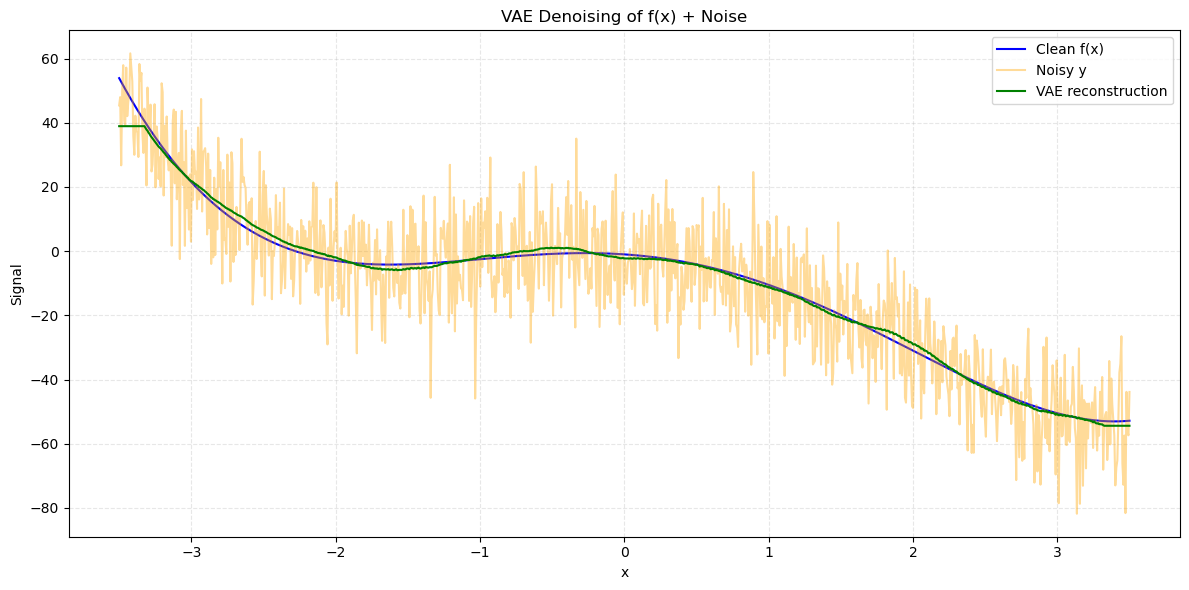

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(x, f, 'b-', label='Clean f(x)')
plt.plot(x, y, 'orange', alpha=0.4, label='Noisy y')
plt.plot(x, recon_signal, 'g-', label='VAE reconstruction')
plt.title("VAE Denoising of f(x) + Noise")
plt.xlabel("x")
plt.ylabel("Signal")
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
